# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>
## <center>Trabajo Práctico 1 : Reservas de Hotel </center>
## <center>Ensambles de Modelos </center>
#### Grupo 29:
* Alen Davies Leccese - 107084
* Luca Lazcano - 107044


# Imports y datasets

Importamos todas las librerias a utilizar en el notebook:

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn as sk
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pickle

RANDOM_STATE = 42

Ahora creamos los DataFrames para trabajar

In [6]:
original = pd.read_csv('/content/hotels_procesado.csv').copy()
original_test = pd.read_csv('/content/hotels_test.csv').copy()
train = pd.read_csv('/content/train_encoded.csv').copy()
test = pd.read_csv('/content/test_encoded.csv').copy()

In [7]:
train.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

# Reduccion de la dimensionalidad

Hacemos reduccion de la dimensionalidad mediante el algoritmo de PCA para disminuir el tiempo de entrenamiento de los modelos

Primero normalizamos los datos

In [8]:
stand_scaler = StandardScaler()
train = stand_scaler.fit_transform(train)
test = stand_scaler.transform(test)

Creamos un primer modelo base de pca para ver la varianza explicada

In [9]:
pca = PCA(n_components = None, random_state = RANDOM_STATE)
train = pca.fit_transform(train)
test = pca.transform(test)

In [10]:
varianza_explicada = pca.explained_variance_ratio_.cumsum()
print(varianza_explicada)

[0.03758965 0.06403069 0.08595653 0.10360483 0.12091669 0.13662005
 0.15166764 0.16608339 0.18005989 0.19306509 0.20554359 0.21796935
 0.2302     0.2423903  0.25455254 0.26656743 0.27835234 0.28998885
 0.30129266 0.31241317 0.32332506 0.33369056 0.34377856 0.35367584
 0.36320813 0.37212197 0.38100801 0.38969653 0.39815582 0.40617419
 0.41405414 0.42165201 0.42910414 0.43652899 0.44388328 0.4511339
 0.45827165 0.46537833 0.47241613 0.47939736 0.48633296 0.49322464
 0.50011187 0.50693175 0.51367965 0.52041116 0.52712024 0.53377695
 0.54039465 0.54700406 0.55357703 0.56010205 0.56661129 0.57310202
 0.57957174 0.58594355 0.59229024 0.59862553 0.60494043 0.61123722
 0.61747964 0.62369543 0.62990184 0.63610389 0.64228338 0.64841873
 0.6545315  0.66062103 0.66668795 0.67273548 0.6787605  0.68475887
 0.69074935 0.69672718 0.7026905  0.70864087 0.71455367 0.72045759
 0.72634151 0.73221346 0.73806949 0.74388648 0.74966754 0.7554338
 0.76118715 0.76692231 0.7726185  0.77829781 0.78395848 0.789573

La graficamos para ver la varianza en funcion de la cantidad de componentes principales

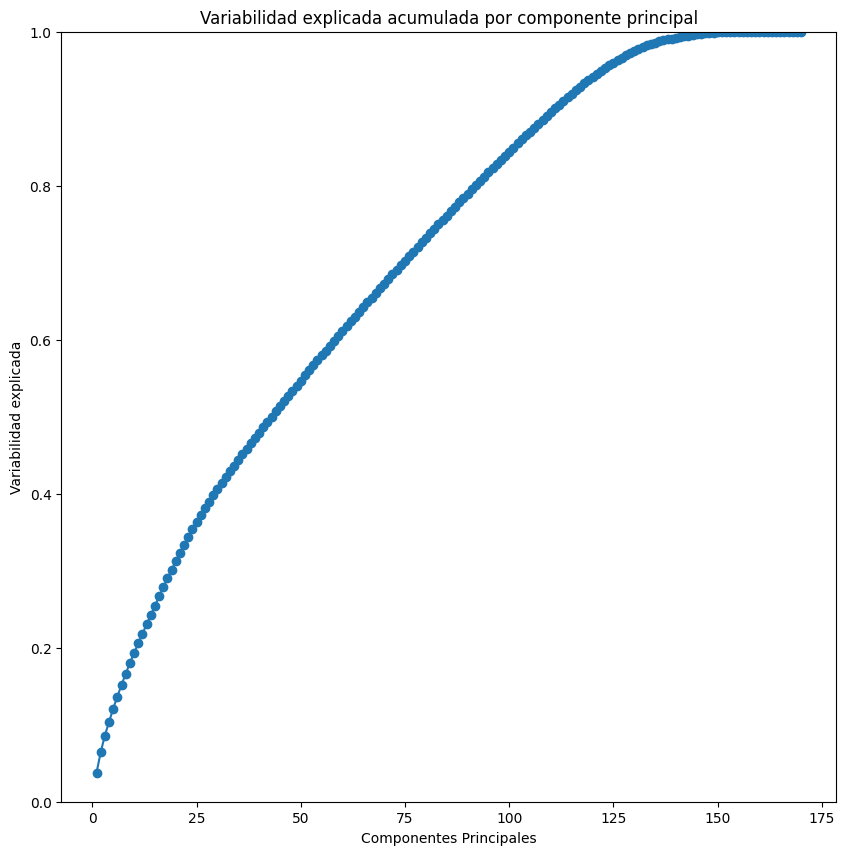

In [11]:
pca_varianza_explicada = pca.explained_variance_ratio_.cumsum()
list_x = list(range(1, len(pca_varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(10, 10))
plt.plot(list_x, pca_varianza_explicada, '-o')
plt.xlabel('Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.title('Variabilidad explicada acumulada por componente principal')
plt.ylim(0, 1)
plt.show()

Podemos ver que aproximadamente entre 100 y 125 componentes, tenemos el mayor porcentaje de la variabilidad total

Entonces entrenamos PCA para hallar la cantidad de componentes basandonos en la varianza explicada deseada. En este caso voy a pedir una varianza explicada del 85%

In [12]:
pca = PCA(n_components = 0.85, random_state = RANDOM_STATE)
train = pca.fit_transform(train)
test = pca.transform(test)

In [13]:
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

Cumulative Variances (Percentage):
[ 3.75896546  6.40306883  8.59565288 10.3604835  12.09166901 13.66200548
 15.16676414 16.60833853 18.00598917 19.30650861 20.55435907 21.79693543
 23.02000016 24.23902955 25.45525415 26.65674344 27.83523385 28.99888537
 30.12926597 31.24131745 32.33250571 33.36905572 34.37785589 35.36758359
 36.32081334 37.21219678 38.10080092 38.96965312 39.81558203 40.61741923
 41.40541393 42.16520149 42.91041398 43.65289905 44.38832775 45.11338957
 45.82716505 46.53783348 47.24161287 47.93973608 48.63329643 49.32246368
 50.0111869  50.69317487 51.36796526 52.04111564 52.71202398 53.37769544
 54.03946492 54.70040645 55.35770289 56.01020451 56.66112863 57.31020209
 57.95717446 58.59435525 59.22902374 59.86255301 60.49404276 61.12372203
 61.74796388 62.36954326 62.99018407 63.61038855 64.22833818 64.84187284
 65.4531502  66.06210281 66.66879535 67.27354845 67.87604981 68.47588697
 69.0749347  69.67271787 70.2690503  70.86408727 71.45536676 72.04575913
 72.63415098 73.

Vemos que el número de componentes necesarios para cubrir el 85% de la varianza explicada es 102 (se puede ver en el gráfico)

Guardamos el modelo de pca en un archivo .pickle

In [14]:
pickle.dump(pca, open('pca_grupo29.pickle', 'wb'))

# Split train/test

Partimos el dataset en los conjuntos de entrenamiento y testing

In [15]:
x = train.copy()
y = original['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=RANDOM_STATE) #semilla

In [16]:
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 37192
# Datos Prueba: 15940
% Positivos Entrenamiento: 50.863
% Positivos Prueba: 50.866


Podemos ver que quedaron bien balanceados los datos

# K-Nearest Neighbors (KNN)

### Modelo con parámetros por defecto

Primero creamos el modelo con los parámetros por defecto

In [13]:
#Crear el modelo con parámetros por defecto
modelo_knn = KNeighborsClassifier()

In [14]:
#Entrenar el modelo
modelo_knn.fit(x_train, y_train)

#Predicción sobre test
y_pred = modelo_knn.predict(x_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.7222710163111669
f1 score: 0.7380628365185492


Con estas metricas tenemos una idea de nuestro modelo base y vamos a tratar de mejorarlas haciendo busqueda de hiperparametros

### Aproximacion inicial a la cantidad de vecinos del modelo

Podemos obtener una primera aproximacion a la cantidad de vecinos a utilizar en nuestro modelo de knn variando la cantidad y viendo su performance en un gráfico

In [16]:
# Variamos la cantidad de vecinos (K)

metrics = [] #cantidad de vecinos y cantidad de aciertos

k_range=range(1,20) 

for n in k_range:

    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, (y_test == y_pred).sum()))

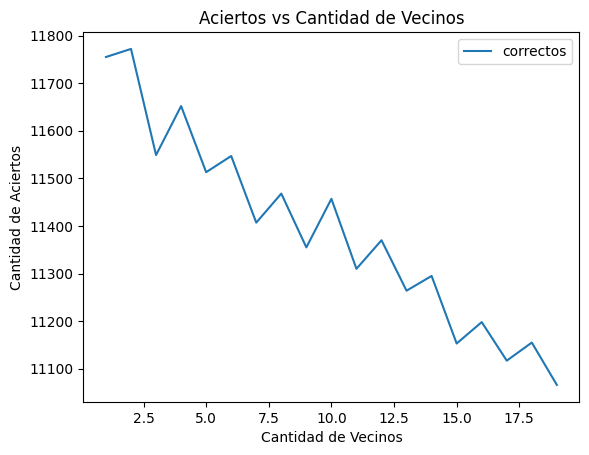

In [17]:
# ploteamos

df_metrics = pd.DataFrame(metrics, columns=['cant_vecinos', 'correctos'])

ax = df_metrics.plot( x='cant_vecinos', 
                      y='correctos',
                      title='Aciertos vs Cantidad de Vecinos'
                     )

ax.set_ylabel("Cantidad de Aciertos")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Podemos ver que el modelo performa mejor con pocos vecinos, en un rango de 1 a 7 es donde tiene mayor cantidad de aciertos y a medida que aumenta la cantidad de vecinos, la cantidad de aciertos disminuye

Ahora disminuimos el rango de vecinos posibles y volvemos a realizar otra aproximacion esta vez utilizando cross validation con 10 folds

In [18]:
k_range = range(1,6) #cantidad de vecinos a probar

k_scores = [] 
scorer_fn = make_scorer(sk.metrics.f1_score)

for k in k_range:
    #clasificador Knn
    knn = KNeighborsClassifier(n_neighbors=k)
    #uso 10 folds
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring=scorer_fn)
    #promedio las 10 métricas
    k_scores.append(scores.mean())

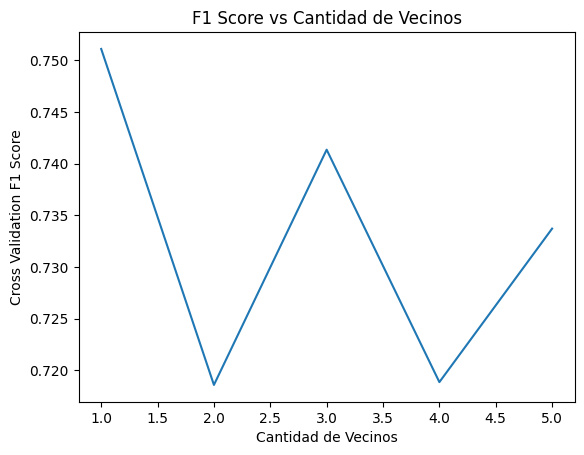

In [19]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('Cross Validation F1 Score')
plt.title('F1 Score vs Cantidad de Vecinos')
plt.show()

Podemos ver con mayor claridad cual seria una buena cantidad de vecinos para probar en nuestro modelo

### Random Search Cross Validation

Hacemos búsqueda de hiperparámetros mediante Random Search Cross Validation con 5 folds para mejorar nuestro modelo base

In [22]:
#Grilla de Parámetros a probar
params_grid={ 'n_neighbors':[1,2,3], # Vecinos basados en el análisis previo
              'weights':['distance'],
              'algorithm':['kd_tree'],
              'metric':['manhattan'],
             }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True)

#Clasificador
knn_model = KNeighborsClassifier()

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_knn = RandomizedSearchCV(estimator = knn_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv, verbose=2) 

rand_knn.fit(x_train, y_train)
rand_knn.cv_results_['mean_test_score']

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=1, weights=distance; total time=  49.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=1, weights=distance; total time=  49.7s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=1, weights=distance; total time=  49.7s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=1, weights=distance; total time=  47.9s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=1, weights=distance; total time=  49.7s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=  55.0s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=  54.6s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=  54.3s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=  57.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=

array([0.74308958, 0.74321518, 0.74716529])

Vemos los parámetros y el score obtenidos luego de realizar Random Search

In [23]:
print('Mejores parámetros: {}'.format(rand_knn.best_params_))
print('Mejor métrica: {}'.format(rand_knn.best_score_))

Mejores parámetros: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
Mejor métrica: 0.7471652926171121


Entrenamos el modelo con los mejores parámetros obtenidos y realizamos las predicciones

In [24]:
knn = KNeighborsClassifier().set_params(**rand_knn.best_params_)
modelo_knn = knn.fit(x_train, y_train)
y_pred = modelo_knn.predict(x_test)

In [32]:
print(f'Best Training Accuracy: {modelo_knn.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_knn.score(x_test, y_test)}')

Best Training Accuracy: 0.9965315121531512
Best Testing Accuracy: 0.73732747804266


Podemos ver que el modelo está un poco overfitteado ya que performa muy bien en los datos de Training pero no tanto en los de Testing

### Métricas

Testeamos el modelo con las métricas mas utilizadas para ver su performance

In [25]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.73732747804266
Recall: 0.7920572274296991
Precision: 0.7197131009750084
f1 score: 0.7541541894192942


In [26]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      7832
           1       0.72      0.79      0.75      8108

    accuracy                           0.74     15940
   macro avg       0.74      0.74      0.74     15940
weighted avg       0.74      0.74      0.74     15940



Podemos ver cuan bien clasificó nuestro modelo mirando la matriz de confusion

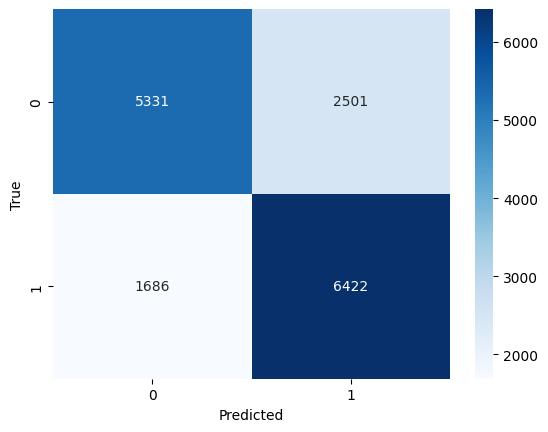

In [28]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

Guardamos el modelo en un archivo .pickle

In [29]:
pickle.dump(modelo_knn, open('knn_grupo29.pickle', 'wb'))

y el .csv con las predicciones para subir a kaggle

In [31]:
X_submission_knn = test
y_pred_test_knn = modelo_knn.predict(X_submission_knn)
df_submission_knn = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_knn})
df_submission_knn.to_csv('knn03.csv', index=False)

# Support Vector Machine (SVM)



#### Modelo con parámetros por default

Creamos un modelos base con sus parámetros por defecto para tener una primera métrica en la cual basarnos

In [33]:
#Crear el modelo con parámetros por defecto
SVM_Classifier = SVC()

In [34]:
#Entrenar el modelo
modelo_svm = SVM_Classifier.fit(x_train, y_train)

#Predicción sobre test
y_pred = SVM_Classifier.predict(x_test)

In [35]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8291091593475534
Recall: 0.8452146028613715
Precision: 0.8234799327084835
f1 score: 0.8342057212416312


Ahora vamos a entrenar modelos de SVM variando el kernel y algunos parámetros

#### Kernel Lineal

Entrenamos un svm con kernel Lineal y vemos su performance:

In [40]:
SVM_Lineal = SVC(kernel='linear', C=1)
modelo_svm = SVM_Lineal.fit(x_train, y_train)
y_pred = SVM_Lineal.predict(x_test)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7696988707653701
Recall: 0.7767636901825358
Precision: 0.7719083220982964
f1 score: 0.7743283949099404


In [42]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      7832
           1       0.77      0.78      0.77      8108

    accuracy                           0.77     15940
   macro avg       0.77      0.77      0.77     15940
weighted avg       0.77      0.77      0.77     15940



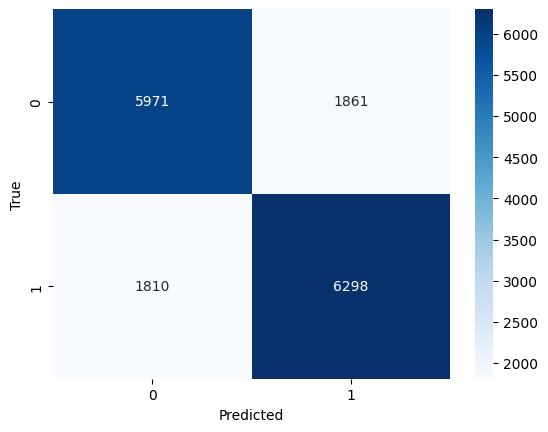

In [43]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Kernel Polinómico

Entrenamos un svm con kernel Polinómico y vemos su performance:

In [13]:
SVM_poly = SVC(kernel='poly', C=2, gamma=3)
modelo_svm = SVM_poly.fit(x_train, y_train)
y_pred = SVM_poly.predict(x_test)

In [14]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7786700125470515
Recall: 0.7993339911198816
Precision: 0.773204485802911
f1 score: 0.7860521528198908


In [15]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      7832
           1       0.77      0.80      0.79      8108

    accuracy                           0.78     15940
   macro avg       0.78      0.78      0.78     15940
weighted avg       0.78      0.78      0.78     15940



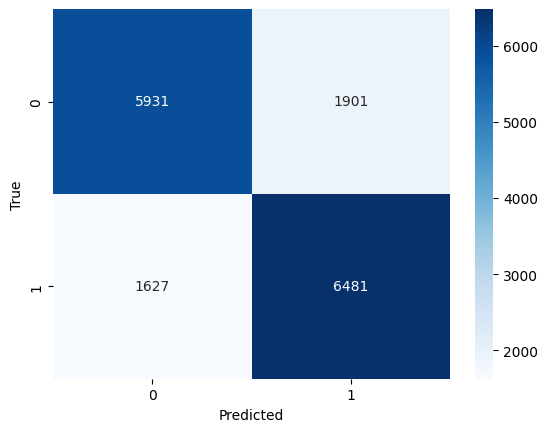

In [16]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Kernel Radial

Entrenamos un svm con kernel Radial y vemos su performance:

In [17]:
SVM_radial = SVC(kernel='rbf', C=3, gamma=5)
modelo_svm = SVM_radial.fit(x_train, y_train)
y_pred = SVM_radial.predict(x_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7462358845671268
Recall: 0.511223482979773
Precision: 0.9806008989827301
f1 score: 0.6720713417105796


In [19]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79      7832
           1       0.98      0.51      0.67      8108

    accuracy                           0.75     15940
   macro avg       0.82      0.75      0.73     15940
weighted avg       0.82      0.75      0.73     15940



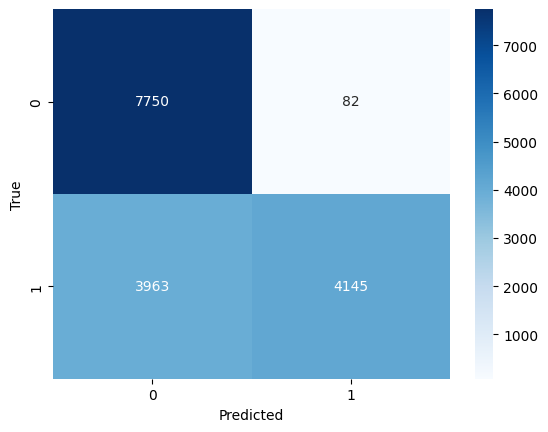

In [20]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Búsqueda de hiperparámetros

Hacemos búsqueda de hiperparámetros con Random Search y utilizando un Bagging Classifier para disminuir el tiempo que tarda el modelo en entrenarse

In [22]:
#Cantidad de combinaciones que quiero probar
n=3

#Grilla de Parámetros
params_grid= {'n_estimators': [10, 20, 30, 40, 50],
              'max_samples': [0.25, 0.5, 0.75, 1.0],
              'max_features': [0.1, 0.25, 0.5, 0.75, 1.0],
              }

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
svm_model = BaggingClassifier(base_estimator=SVC(kernel='rbf'))

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_svm = RandomizedSearchCV(estimator = svm_model,
                              param_distributions = params_grid,
                              scoring = scorer_fn, n_iter=n, verbose=2) 

rand_svm.fit(x_train, y_train)
rand_svm.cv_results_['mean_test_score']

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time= 2.5min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time= 2.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END .max_features=0.5, max_samples=0.5, n_estimators=10; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=0.5, max_samples=0.75, n_estimators=30; total time=11.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=0.5, max_samples=0.75, n_estimators=30; total time=10.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=0.5, max_samples=0.75, n_estimators=30; total time=11.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=0.5, max_samples=0.75, n_estimators=30; total time=11.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=0.5, max_samples=0.75, n_estimators=30; total time=11.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=1.0, max_samples=0.75, n_estimators=30; total time=14.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=1.0, max_samples=0.75, n_estimators=30; total time=14.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=1.0, max_samples=0.75, n_estimators=30; total time=14.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=1.0, max_samples=0.75, n_estimators=30; total time=15.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


[CV] END max_features=1.0, max_samples=0.75, n_estimators=30; total time=15.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


array([0.79348979, 0.80830349, 0.82735204])

Ahora podemos ver los parámetros y el mejor score obtenidos luego de realizar Random Search

In [23]:
print('Mejores parámetros: {}'.format(rand_svm.best_params_))
print('Mejor métrica: {}'.format(rand_svm.best_score_))

Mejores parámetros: {'n_estimators': 30, 'max_samples': 0.75, 'max_features': 1.0}
Mejor métrica: 0.8273520388734121


Obtenemos las predicciones del modelo

In [24]:
y_pred = rand_svm.best_estimator_.predict(x_test)

### Métricas

Ahora vemos que tan bien performa el modelo calculando las métricas y mostrando la matriz de confusion

In [25]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8272898368883312
Recall: 0.836211149481993
Precision: 0.8263254113345521
f1 score: 0.8312388892294489


In [26]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82      7832
           1       0.83      0.84      0.83      8108

    accuracy                           0.83     15940
   macro avg       0.83      0.83      0.83     15940
weighted avg       0.83      0.83      0.83     15940



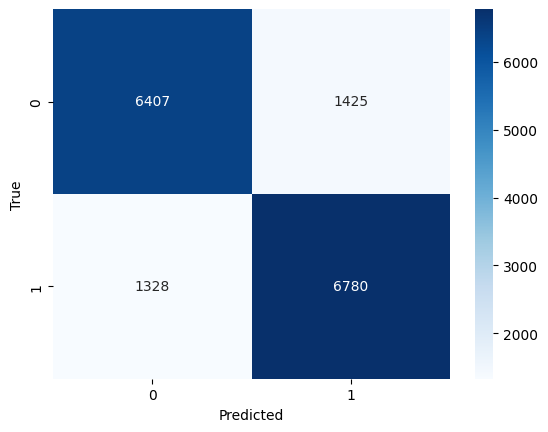

In [27]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission y conclusiones

Guardamos el modelo

In [29]:
pickle.dump(rand_svm.best_estimator_, open('svm_grupo29.pickle', 'wb'))

Y la submission para subir a Kaggle

In [30]:
X_submission_svm = test
y_pred_test_svm = rand_svm.best_estimator_.predict(X_submission_svm)
df_submission_svm = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_svm})
df_submission_svm.to_csv('svm02.csv', index=False)

# Random Forest

Creamos un modelo base con sus parámetros por defecto

In [ ]:
modelo_rf = RandomForestClassifier()
modelo_rf.fit(x_train, y_train)
  
y_pred = modelo_rf.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.8741530740276036
f1 score: 0.8746719980007497


### Random Search Cross Validation

Ahora tratamos de mejorar el modelo base mediante búsqueda de hiperparámetros con Random Search cross validation con 10 folds

In [ ]:
#Cantidad de combinaciones que quiero probar
n=5

#Grilla de Parámetros
params_grid={ 'n_estimators':      list(range(10,161,10)),
                'min_samples_split': list(range(2,15)),
                'max_depth':         [None],
                'max_samples':       np.linspace(0.5,1,n)
             }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)

#Clasificador
modelo_rf = RandomForestClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_rf = RandomizedSearchCV(estimator = modelo_rf,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_rf.fit(x_train, y_train)
rand_rf.cv_results_['mean_test_score']

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.1s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.9s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   7.9s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   8.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   7.8s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   9.3s
[CV] END max_depth=None, max_samples=1.0, min_samples_split=3, n_estimators=130; total time=   9.4s
[CV] END max_depth=None, max_samples=1.

array([0.87764186, 0.87255552, 0.87143985, 0.87335465, 0.87248101])

In [ ]:
print('Mejores parámetros: {}'.format(rand_rf.best_params_))
print('Mejor métrica: {}'.format(rand_rf.best_score_))

Mejores parámetros: {'n_estimators': 130, 'min_samples_split': 3, 'max_samples': 1.0, 'max_depth': None}
Mejor métrica: 0.8776418629671225


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE).set_params(**rand_rf.best_params_)
modelo_rf = rf.fit(x_train, y_train)
y_pred = modelo_rf.predict(x_test)

In [ ]:
print(f'Best Training Accuracy: {modelo_rf.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_rf.score(x_test, y_test)}')

Best Training Accuracy: 0.9954291245429124
Best Testing Accuracy: 0.8806148055207026


### Métricas

Vemos que tan bueno es el modelo, calculando las métricas y la matriz de confusion

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred,)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8806148055207026
Recall: 0.8771583621114948
Precision: 0.8868936276343684
f1 score: 0.8819991318906182


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      7832
           1       0.89      0.88      0.88      8108

    accuracy                           0.88     15940
   macro avg       0.88      0.88      0.88     15940
weighted avg       0.88      0.88      0.88     15940



In [ ]:
print(classification_report(y_train, modelo_rf.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18275
           1       0.99      1.00      1.00     18917

    accuracy                           1.00     37192
   macro avg       1.00      1.00      1.00     37192
weighted avg       1.00      1.00      1.00     37192



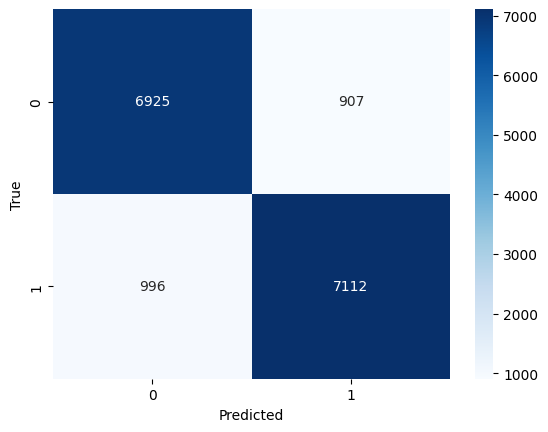

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Visualizacion del árbol y feature importance

Podemos ver que features son importantes para el modelo ordenadas de mayor a menos importancia

In [ ]:
feat_imps = rf.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,x.columns), reverse=True):
  if feat_imp > 0.01:
    print('{}: {}'.format(feat,feat_imp))

lead_time: 0.09424247011041242
country_PRT: 0.07725692538975933
deposit_type_Non Refund: 0.05498718429458808
total_of_special_requests: 0.052572140870440105
adr: 0.0500707741752953
deposit_type_No Deposit: 0.04906966582679281
stays_in_week_nights: 0.025075279637032877
required_car_parking_spaces: 0.021182238709646528
previous_cancellations: 0.019662077260996287
booking_changes: 0.019226724222215812
market_segment_Online TA: 0.017735133930335472
agent_10000: 0.017423472898257776
agent_9: 0.01660767900863189
stays_in_weekend_nights: 0.016386730968183945
customer_type_Transient: 0.01445066425000167
assigned_room_type_A: 0.013550622227748351
customer_type_Transient-Party: 0.01256027460621416
market_segment_Groups: 0.01213664025144553


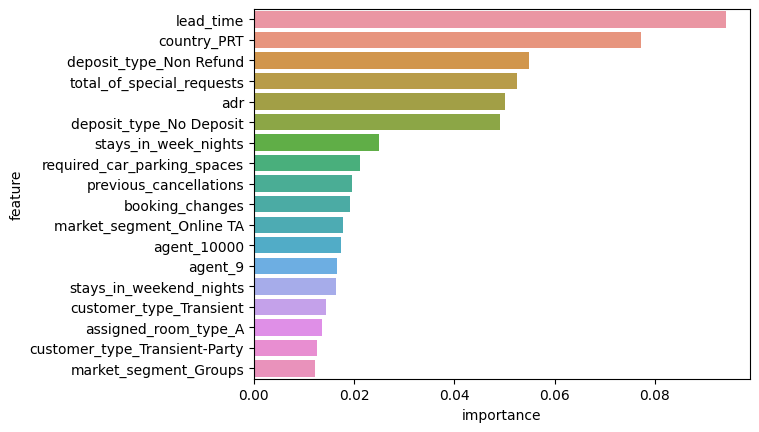

In [ ]:
feat_imp_df = pd.DataFrame({'feature':x.columns,'importance':feat_imps})
feat_imp_df = feat_imp_df[feat_imp_df['importance']>0.01]
feat_imp_df = feat_imp_df.sort_values(by='importance',ascending=False)
sns.barplot(x='importance',y='feature',data=feat_imp_df)
plt.show()

Graficamos una porcion representativa de uno de los estimadores de nuestro modelo de Random Forest

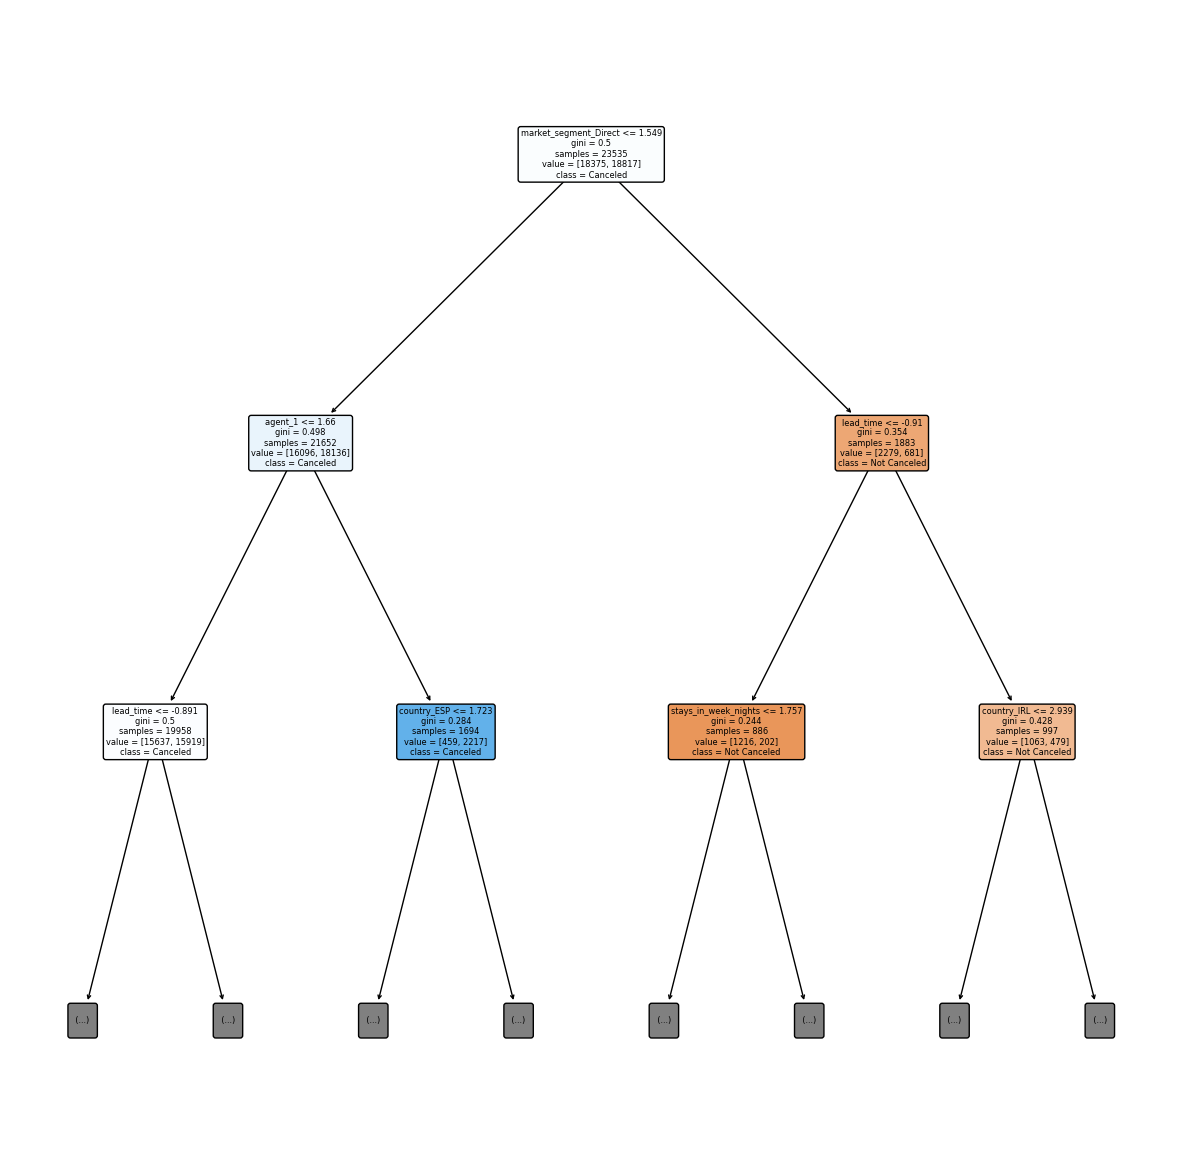

In [ ]:
plt.figure(figsize=(15, 15))

tree_plot = plot_tree(modelo_rf.estimators_[0],
                           max_depth=2,
                           feature_names=x.columns.to_list(),
                           filled=True,
                           rounded=True,
                           class_names=['Not Canceled', 'Canceled'])
plt.show(tree_plot)

### Submission

Guardamos el modelo en un archivo .pickle

In [ ]:
pickle.dump(modelo_rf, open('rf_grupo29.pickle', 'wb'))

Y el .csv para subir a Kaggle

In [ ]:
X_submission_rf = test.select_dtypes(exclude=['object'])
y_pred_test_rf = modelo_rf.predict(X_submission_rf)
df_submission_rf = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_rf})
df_submission_rf.to_csv('rf02.csv', index=False)

# XGBoost

### Modelo con parámetros por default

Creamos un modelo base con sus parámetros por defecto

In [ ]:
modelo_xgb = XGBClassifier(random_state=RANDOM_STATE)
modelo_xgb.fit(x_train, y_train)
y_pred = modelo_xgb.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("f1 score: "+str(f1))

Accuracy: 0.8718946047678795
f1 score: 0.8751223091976518


In [ ]:
print(f'Best Training Accuracy: {modelo_xgb.score(x_train, y_train)}')
print(f'Best Testing Accuracy: {modelo_xgb.score(x_test, y_test)}')

Best Training Accuracy: 0.9065659281565929
Best Testing Accuracy: 0.8718946047678795


Podemos ver que el modelo base ya performa muy bien pero vamos a buscar hiperparámetros igualmente

### Random Search Cross Validation

Hacemos búsqueda de hiperparámetros mediante Random Search cross validation con 5 folds

In [ ]:
#Cantidad de combinaciones que quiero probar
n=10

#Grilla de Parámetros
params_grid= {'learning_rate': np.linspace(0.05, 0.5, 50),
                'gamma': [0,1,2],
                'max_depth': list(range(2,10)),
                'subsample': np.linspace(0, 1, 20),
                'lambda': [0,1,2],
                'alpha' : [1],
                'n_estimators': list(range(10,161,10))
              }
folds = 5
#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
xgb = XGBClassifier(random_state=RANDOM_STATE)

# Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
rand_xgb = RandomizedSearchCV(estimator = xgb,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv=kfoldcv,
                              n_iter = n,
                              random_state=RANDOM_STATE, verbose=2) 

rand_xgb.fit(x_train, y_train)
rand_xgb.cv_results_['mean_test_score']

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  46.8s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  48.3s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  45.2s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  46.9s
[CV] END alpha=1, gamma=2, lambda=2, learning_rate=0.1969387755102041, max_depth=8, n_estimators=120, subsample=0.5263157894736842; total time=  48.6s
[CV] END alpha=2, gamma=1, lambda=0, learning_rate=0.3346938775510204, max_depth=4, n_estimators=160, subsample=0.3684210526315789; total time=  25.6s
[CV] END alpha=2, gamma=1, lambda

array([0.87000869, 0.86074654, 0.8613553 , 0.8662935 , 0.85083807,
       0.85299663, 0.        , 0.83558883, 0.86701917, 0.85478763])

Vemos los parámetros elegidos y el mejore score obtenidos

In [ ]:
print('Mejores parámetros: {}'.format(rand_xgb.best_params_))
print('Mejor métrica: {}'.format(rand_xgb.best_score_))

Mejores parámetros: {'subsample': 0.5263157894736842, 'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.1969387755102041, 'lambda': 2, 'gamma': 2, 'alpha': 1}
Mejor métrica: 0.8700086861780193


Obtenemos las predicciones del modelo

In [ ]:
modelo_xgb = XGBClassifier(random_state=RANDOM_STATE).set_params(**rand_xgb.best_params_)
modelo_xgb.fit(x_train, y_train)
y_pred = modelo_xgb.predict(x_test)

### Métricas

Evaluamos el modelo calculando las métricas y la matriz de confusion

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8696361355081555
Recall: 0.8804884065120868
Precision: 0.8655431619786615
f1 score: 0.8729518219613597


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      7832
           1       0.87      0.88      0.87      8108

    accuracy                           0.87     15940
   macro avg       0.87      0.87      0.87     15940
weighted avg       0.87      0.87      0.87     15940



In [ ]:
print(classification_report(y_train, modelo_xgb.predict(x_train)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     18275
           1       0.90      0.92      0.91     18917

    accuracy                           0.91     37192
   macro avg       0.91      0.91      0.91     37192
weighted avg       0.91      0.91      0.91     37192



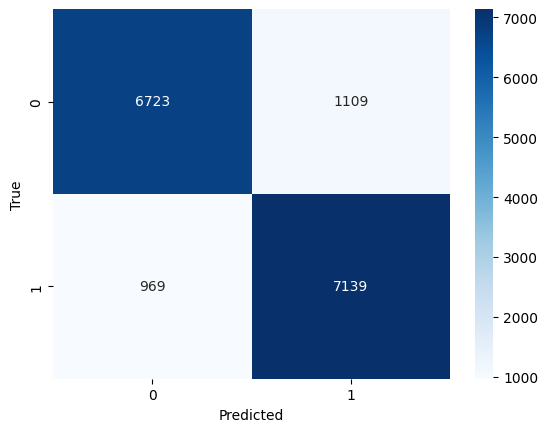

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Submission

Guardamos el modelo en un archivo .pickle

In [ ]:
pickle.dump(modelo_xgb, open('xgb_grupo29.pickle', 'wb'))

Y el archivo .csv para subir a Kaggle

In [ ]:
X_submission_xgb = test.select_dtypes(exclude=['object'])
y_pred_test_xgb = modelo_xgb.predict(X_submission_xgb)
df_submission_xgb = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_xgb})
df_submission_xgb.to_csv('xgb01.csv', index=False)

# Voting Classifier

In [ ]:
def score(model, X, y):
     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
     scores = cross_val_score(model, X, y, scoring='f1', cv=cv, error_score='raise')
     return scores

Se crean los clasificadores que se utilizarán para el ensamble híbrido, en este caso se eligió Random Forest, Decision Tree y KNN

In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=40)
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
knn = KNeighborsClassifier(n_neighbors=7)

Evaluamos la performance de cada uno de los clasificadores por separado 

In [ ]:
models = {'random_forest': rf,
               'tree': tree,
               'knn': knn}

resultado, nombres = list(), list()
for nombre, model in models.items():
	scores = score(model, x_train, y_train)
	resultado.append(scores)
	nombres.append(nombre)
	print('%s %.3f' % (nombre, mean(scores)))

random_forest 0.871
tree 0.838
knn 0.728


Creamos el Voting Classifier, lo entrenamos con los datos y obtenemos las predicciones

In [ ]:
#Creo ensemble de Votación
voting = VotingClassifier(estimators = [('random_forest', rf), ('tree', tree), ('knn', knn)], voting = 'hard', n_jobs=-1)

#Entreno el ensemble
modelo_voting = voting.fit(x_train, y_train)

#Evaluo en conjunto de test
y_pred = voting.predict(x_test)

Ahora evaluamos la performance del Voting Classifier calculando las métricas y la matriz de confusion

In [ ]:
score_voting = score(voting, x_train, y_train)
print('Voting Classifier:', mean(score_voting))

Voting Classifier: 0.8594893037172796


In [ ]:
resultado.append(score_voting)
nombres.append('voting')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8631744040150564
Recall: 0.8660582141095214
Precision: 0.8650979425896267
f1 score: 0.8655778120184899


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      7832
           1       0.87      0.87      0.87      8108

    accuracy                           0.86     15940
   macro avg       0.86      0.86      0.86     15940
weighted avg       0.86      0.86      0.86     15940



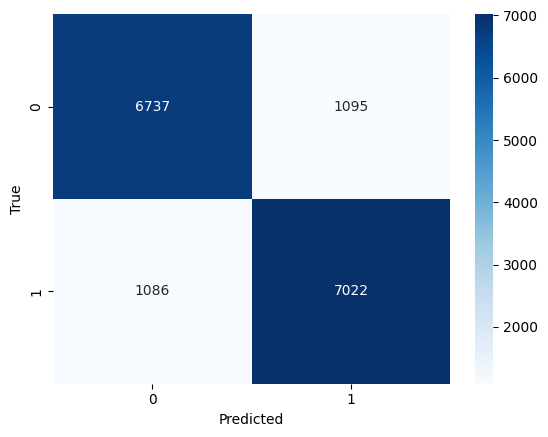

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ahora podemos comparar la performance de los modelos utilizados con la del ensamble

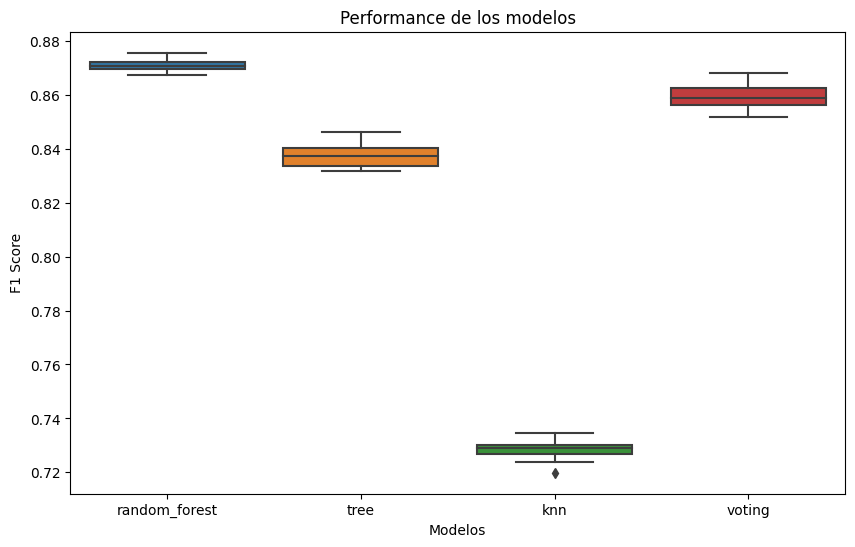

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(resultado).set(xticklabels=nombres, title='Performance de los modelos', xlabel='Modelos', ylabel='F1 Score')
plt.show()

Podemos ver que como la predicción final se basa en la mayoría de los votos de los modelos base, obtenemos un modelo que en general posee mayor precision que los modelos individuales. Esto se debe a que puede aprovechar las fortalezas de cada modelo base y reducir el impacto de las debilidades individuales.

En este caso en particular, el random_forest es mucho mejor que los otros dos modelos. Pero al ensamblarlos en un voting obtenemos un modelo que es bastante mejor que el decision tree y que el knn aunque apenas peor que el random forest.

### Submission

Guardamos el modelo en un archivo .pickle

In [ ]:
pickle.dump(modelo_voting, open('voting_grupo29.pickle', 'wb'))

y el archivo .csv para subir a Kaggle

In [ ]:
X_submission_voting = test.select_dtypes(exclude=['object'])
y_pred_test_voting = modelo_voting.predict(X_submission_voting)
df_submission_voting = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_voting})
df_submission_voting.to_csv('voting00.csv', index=False)

# Stacking Classifier

Creamos los modelos a utilizar en el ensamble, en este caso se utilizarán random forest, KNN y XGBoost


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=60)
knn = KNeighborsClassifier(n_neighbors=3)
xgboost = xgb.XGBClassifier(random_state=RANDOM_STATE)

Evaluamos los modelos por separado

In [ ]:
base_models = {'random_forest': rf,
               'knn': knn,
               'xgboost': xgboost}

result, names = list(), list()
for name, model in base_models.items():
	scores = score(model, x_train, y_train)
	result.append(scores)
	names.append(name)
	print('%s %.3f' % (name, mean(scores)))

random_forest 0.873
knn 0.743
xgboost 0.871


Creamos el Stacking Classifier, lo entrenamos con los datos y obtenemos las predicciones

In [ ]:
#Modelos Base
modelos_base = [('random_forest', rf), ('knn', knn), ('xgboost', xgboost)]

#Meta Modelo
meta_model = LogisticRegression()

#Ensemble Stacking
stacking = StackingClassifier(estimators=modelos_base, final_estimator=meta_model, cv=5)

modelo_stacking = stacking.fit(x_train, y_train)

y_pred = stacking.predict(x_test)

Evaluamos la performance del Stacking calculando las métricas y la matriz de confusion

In [ ]:
score_stacking = score(stacking, x_train, y_train)
print('Stacking Classifier:', mean(score_stacking))

Stacking Classifier: 0.8781978976988492


In [ ]:
result.append(score_stacking)
names.append('stacking')

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8801756587202008
Recall: 0.8856684755796744
Precision: 0.8795933365997061
f1 score: 0.8826204523107178


In [ ]:
#Reporte de Clasificación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      7832
           1       0.88      0.89      0.88      8108

    accuracy                           0.88     15940
   macro avg       0.88      0.88      0.88     15940
weighted avg       0.88      0.88      0.88     15940



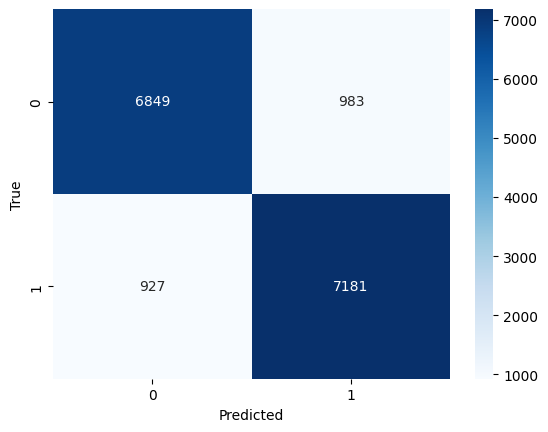

In [ ]:
#Matriz de Confusión
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

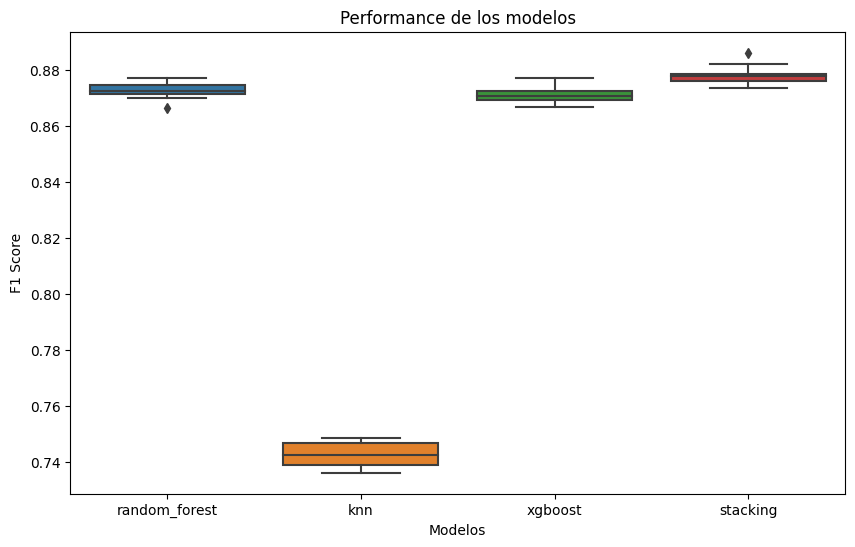

In [ ]:
#Grafico performance
plt.figure(figsize=(10,6))
sns.boxplot(result).set(xticklabels=names, title='Performance de los modelos', xlabel='Modelos', ylabel='F1 Score')
plt.show()

Ya que el modelo meta se entrena utilizando las predicciones realizadas por los modelos base, obtenemos un modelo con una mejor performance que los modelos base por separados

En este caso tenemos dos modelos bases muy buenos: random forest y xgboost y aun asi el stacking classifier es mejor que ellos.

### Submission

Guardamos el model en un archivo .pickle

In [ ]:
pickle.dump(modelo_stacking, open('stacking_grupo29.pickle', 'wb'))

y el archivo .csv para subir a Kaggle

In [ ]:
X_submission_stacking = test.select_dtypes(exclude=['object'])
y_pred_test_stacking = modelo_stacking.predict(X_submission_stacking)
df_submission_stacking = pd.DataFrame({'id': original_test['id'], 'is_canceled': y_pred_test_stacking})
df_submission_stacking.to_csv('stacking00.csv', index=False)